<a href="https://colab.research.google.com/github/prakhar-chaurasiya/ml/blob/main/makemore_mlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[nn-zero-to-hero](https://github.com/karpathy/nn-zero-to-hero)

[makemore](https://github.com/karpathy/makemore)

# [Building makemore Part 2: MLP](https://www.youtube.com/watch?v=TCH_1BHY58I&list=PLAqhIrjkxbuWI23v9cThsA9GvCAUhRvKZ&index=3&ab_channel=AndrejKarpathy)

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline
import requests

In [2]:
f = requests.get('https://raw.githubusercontent.com/karpathy/makemore/master/names.txt')
words = f.text.splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

In [3]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [4]:
# build the dataest

block_size = 3 # context length: how many characters do we take to predict the next one?
X, Y = [], []
# for w in words:
for w in words:
  # print(w)
  context = [0] * block_size
  for ch in w + '.':
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    # print(''.join(itos[i] for i in context), '--->', itos[ix])
    context = context[1:] + [ix] # crop and append
X = torch.tensor(X)
Y = torch.tensor(Y)

In [5]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

In [15]:
# build the dataset

def build_dataset(words):
  block_size = 3 # context length: how many characters do we take to predict the next one?
  X, Y = [], []
  for w in words:
    # print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop append
  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [25]:
C = torch.randn((27, 2))

In [26]:
C[5]

tensor([0.7785, 0.0053])

In [27]:
F.one_hot(torch.tensor(5), num_classes=27).float() @ C

tensor([0.7785, 0.0053])

In [28]:
emb = C[X]
emb.shape

torch.Size([32, 3, 2])

In [29]:
W1 = torch.randn((6, 100))
b1 = torch.randn(100)

In [30]:
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)

In [31]:
h

tensor([[-0.7142,  0.8984, -0.8914,  ...,  0.4014, -0.9541, -0.8143],
        [-0.8751,  0.9193, -0.9866,  ...,  0.8339, -0.9884, -0.6239],
        [-0.9517,  0.6634, -0.9998,  ...,  0.9920, -0.9869, -0.4649],
        ...,
        [-0.9992, -0.7331, -0.9206,  ..., -0.8648, -0.0637, -0.9926],
        [-0.8457,  0.9774,  0.9942,  ..., -0.8698, -0.9292, -0.6087],
        [-0.9987,  0.8904, -0.9999,  ...,  0.9835, -0.9987,  0.2252]])

In [32]:
h.shape

torch.Size([32, 100])

In [33]:
W2 = torch.randn((100, 27))
b2 = torch.randn(27)

In [34]:
logits = h @ W2 + b2

In [35]:
logits.shape

torch.Size([32, 27])

In [36]:
counts = logits.exp()

In [37]:
prob = counts / counts.sum(1, keepdims=True)

In [38]:
prob.shape

torch.Size([32, 27])

In [39]:
loss = -prob[torch.arange(32), Y].log().mean()
loss

tensor(14.8267)

combine into one

In [25]:
Xtr.shape, Ytr.shape # dataset

(torch.Size([182625, 3]), torch.Size([182625]))

In [26]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 300), generator=g)
b1 = torch.randn(300, generator=g)
W2 = torch.randn((300, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [27]:
sum(p.nelement() for p in parameters)

10281

In [28]:
for p in parameters:
  p.requires_grad = True

In [10]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre
# lrs

In [42]:
lri = []
lossi = []
stepi = []

for i in range(30000):
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (32,))
  # forward pass
  emb = C[Xtr[ix]] # 32, 3, 2
  h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
  logits = h @ W2 + b2 # (32, 27)
  loss = F.cross_entropy(logits, Ytr[ix])
  # print(loss.item())

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  # lr = lrs[i]
  lr = 0.01
  for p in parameters:
    p.data += -lr * p.grad
  
  # track stats
  # lri.append(lre[i])
  stepi.append(i)
  lossi.append(loss.item())
# print(loss.item())

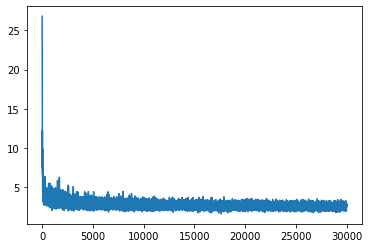

In [30]:
plt.plot(stepi, lossi)

In [23]:
print(loss.item())

2.0616743564605713


In [43]:
emb = C[Xtr]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.2313, grad_fn=<NllLossBackward0>)

In [44]:
emb = C[Xdev]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.2373, grad_fn=<NllLossBackward0>)

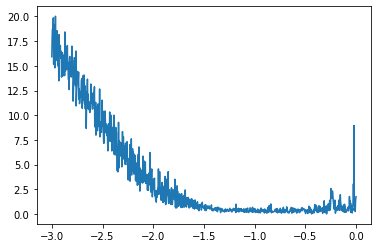

In [56]:
plt.plot(lri, lossi)

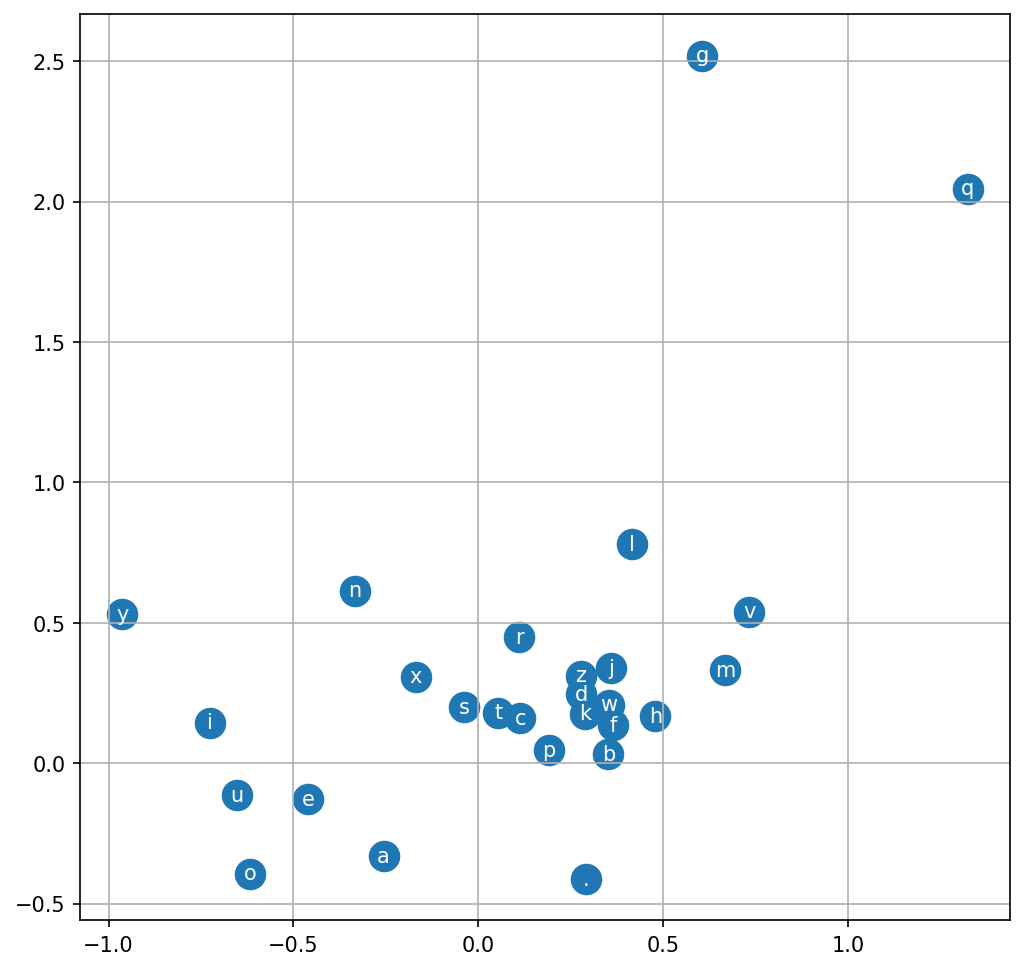

In [47]:
plt.figure(figsize=(8,8), dpi=150)
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
  plt.text(C[i,0].item(), C[i, 1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [47]:
torch.cat(torch.unbind(emb, 1), 1)

tensor([[-0.0259, -0.9681,  0.4753, -1.7638, -0.0259, -0.9681],
        [ 0.9055,  1.8737,  1.7257, -1.5040, -0.0259, -0.9681],
        [ 3.0363, -0.7694,  3.0363, -0.7694,  3.0363, -0.7694],
        [ 3.0363, -0.7694,  3.0363, -0.7694, -0.0259, -0.9681],
        [ 0.8661, -3.7134,  0.4753, -1.7638,  0.8661, -3.7134],
        [ 3.0363, -0.7694,  0.8661, -3.7134,  0.4753, -1.7638],
        [ 3.0363, -0.7694,  3.0363, -0.7694, -0.5283,  1.9941],
        [-0.0259, -0.9681,  0.4753, -1.7638, -0.0259, -0.9681],
        [ 3.0363, -0.7694,  3.0363, -0.7694,  0.8661, -3.7134],
        [ 3.0363, -0.7694,  3.0363, -0.7694,  3.0363, -0.7694],
        [-0.0259, -0.9681,  0.4753, -1.7638, -0.0259, -0.9681],
        [ 3.0363, -0.7694,  3.0363, -0.7694,  3.0363, -0.7694],
        [-1.4433, -2.6085, -1.1066, -0.0999,  0.9055,  1.8737],
        [-0.0259, -0.9681,  0.4753, -1.7638, -0.0259, -0.9681],
        [-0.5283,  1.9941,  1.9502, -1.2416,  1.9502, -1.2416],
        [ 0.8661, -3.7134,  0.5442,  0.1

In [48]:
emb.storage()

 -0.025873104110360146
 -0.9680628776550293
 0.47533118724823
 -1.7637661695480347
 -0.025873104110360146
 -0.9680628776550293
 0.9055367708206177
 1.873691439628601
 1.725700855255127
 -1.5040422677993774
 -0.025873104110360146
 -0.9680628776550293
 3.036344051361084
 -0.7694247364997864
 3.036344051361084
 -0.7694247364997864
 3.036344051361084
 -0.7694247364997864
 3.036344051361084
 -0.7694247364997864
 3.036344051361084
 -0.7694247364997864
 -0.025873104110360146
 -0.9680628776550293
 0.8661141991615295
 -3.713409900665283
 0.47533118724823
 -1.7637661695480347
 0.8661141991615295
 -3.713409900665283
 3.036344051361084
 -0.7694247364997864
 0.8661141991615295
 -3.713409900665283
 0.47533118724823
 -1.7637661695480347
 3.036344051361084
 -0.7694247364997864
 3.036344051361084
 -0.7694247364997864
 -0.5283402800559998
 1.9941269159317017
 -0.025873104110360146
 -0.9680628776550293
 0.47533118724823
 -1.7637661695480347
 -0.025873104110360146
 -0.9680628776550293
 3.036344051361084
 